# 0. Load parameters


In [6]:
# | tags: [parameters]
subject_id = 101  # or whatever subject you're working with

In [7]:
from pathlib import Path
import os
import mne
import matplotlib.pyplot as plt
import numpy as np

from spectral.preproc import (
    load_data,
    zapline_clean,
    apply_pyprep,
)
from spectral.utils import ProjectPaths, print_timestamp, load_config

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")

# Initialize paths for your subject
paths = ProjectPaths(subject_id)

# Create all directories
paths.create_directories()

# Print paths to verify
print_timestamp("Setting up project paths")
paths.show()

Created directories for sub-101
Project root: /Users/daniel/PhD/Projects/psd-paths
Setting up project paths: 2025-07-30 22:25:30
────────────────────────────────────────────────────────────
Paths for sub-101
Project Root: /Users/daniel/PhD/Projects/psd-paths
────────────────────────────────────────────────────────────
  analysis     : /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/analysis
  data         : /Users/daniel/PhD/Projects/psd-paths/data/raw/sub-101
  epochs       : /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/epochs
  figures      : /Users/daniel/PhD/Projects/psd-paths/outputs/figures/sub-101
  ica          : /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/analysis/ica
  logs         : /Users/daniel/PhD/Projects/psd-paths/data/logs
  outputs      : /Users/daniel/PhD/Projects/psd-paths/outputs
  preprocessed : /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/preprocessed
  processing   : /Users/daniel/PhD/Projects

This file contains preprocessing files after downsampling them.


# 1. Preprocess raw data


In [8]:
# Load the configuration from settings toml file
# The file should be named 'settings.toml' and located in the root directory and contain the preprocessing parameters
# e.g., channels to remove, filter parameters, etc.

config = load_config()

# Access the bad channels list
bad_channels = config["preprocessing"]["channels_to_remove"]
print(f"Channels to remove: {bad_channels}")

fline = [50, 100]  # Line noise frequencies
h_freq = 40
l_freq = 1

filter_params = {
    "l_freq": l_freq,
    "h_freq":h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin",
    "phase": "zero",
    "picks": ["ecg", "eeg"],
}

raw = load_data(subject_id, data_path=paths.data).resample(
    250, method="polyphase", verbose=True
)
total_duration = raw.times[-1]

raw_filtered = (
    raw.copy()
    .resample(250, method="polyphase", verbose=True)
    .drop_channels(bad_channels)
    .notch_filter(freqs=[fline], method="fir",   picks=['eeg', 'ecg'])
    .filter(**filter_params)
    .crop(tmin=3.0, tmax=total_duration - 3, include_tmax=True)
)

Channels to remove: ['E67', 'E73', 'E82', 'E91', 'E92', 'E102', 'E111', 'E120', 'E133', 'E145', 'E165', 'E174', 'E187', 'E199', 'E208', 'E209', 'E216', 'E217', 'E218', 'E219', 'E225', 'E226', 'E227', 'E228', 'E229', 'E230', 'E231', 'E232', 'E233', 'E234', 'E235', 'E236', 'E237', 'E238', 'E239', 'E240', 'E241', 'E242', 'E243', 'E244', 'E245', 'E246', 'E247', 'E248', 'E249', 'E250', 'E251', 'E252', 'E253', 'E254', 'E255', 'E256']
Loading data from: /Users/daniel/PhD/Projects/psd-paths/data/raw/sub-101/ses-01/eeg/sub-101_ses-01_task-rest_eeg.set
Loaded 258 channels, 300.4 seconds of data
Identified ECG channels: ['ECG']
Removed 'VREF' channel.
Applying GSN-HydroCel-256 montage...
Polyphase resampling neighborhood: ±2 input samples
Sampling frequency of the instance is already 250.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowe

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


Text(0.5, 1.0, 'sub-101 PSD')

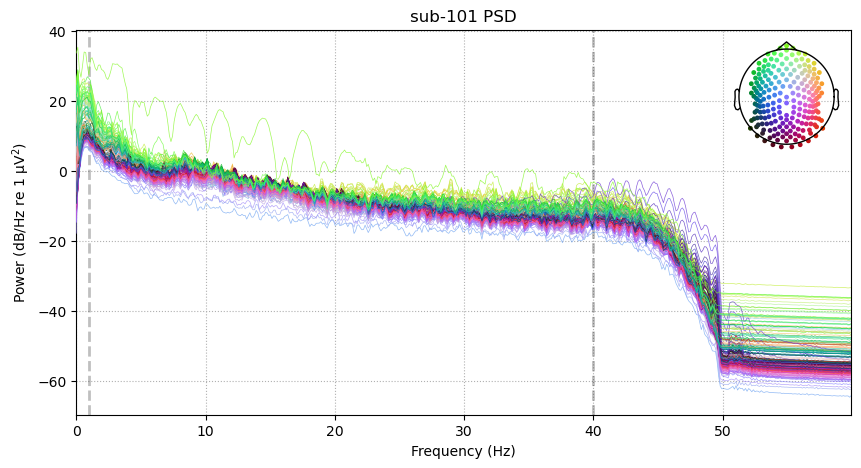

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
raw_psd = raw_filtered.compute_psd(
    fmax=60.0, method="welch", picks="eeg", exclude="bads"
).plot(average=False, picks="eeg", exclude="bads", show=False, axes=ax, amplitude=False)
ax.set_title(f"sub-{subject_id} PSD")

In [10]:
iter_param = {
    "n_iter_max": 100,
    "win_sz": 12.5,
    "spot_sz": 6,
}

filter_params = {
    "l_freq": 1,
    "h_freq": 100,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
    "picks": ["ecg", "eeg"],
}

raw = load_data(subject_id, data_path=paths.data)
total_duration = raw.times[-1]

raw_zap = (
    raw.copy()
    .drop_channels(bad_channels)
    .filter(**filter_params)
    .crop(tmin=3.0, tmax=total_duration - 3, include_tmax=True)
)


zap = zapline_clean(raw_zap, fline=50.0, ntimes=3, method="line", iter_param=iter_param)

Loading data from: /Users/daniel/PhD/Projects/psd-paths/data/raw/sub-101/ses-01/eeg/sub-101_ses-01_task-rest_eeg.set
Loaded 258 channels, 300.4 seconds of data
Identified ECG channels: ['ECG']
Removed 'VREF' channel.
Applying GSN-HydroCel-256 montage...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 s)



/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/meegkit/dss.py:120: RuntimeWarning: divide by zero encountered in matmul
  c2 = (eigvec0 @ W).T @ c1 @ (eigvec0 @ W)
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/meegkit/dss.py:120: RuntimeWarning: overflow encountered in matmul
  c2 = (eigvec0 @ W).T @ c1 @ (eigvec0 @ W)
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/meegkit/dss.py:120: RuntimeWarning: invalid value encountered in matmul
  c2 = (eigvec0 @ W).T @ c1 @ (eigvec0 @ W)
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/meegkit/dss.py:126: RuntimeWarning: divide by zero encountered in matmul
  todss = eigvec0 @ W @ eigvec2
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/meegkit/dss.py:126: RuntimeWarning: overflow encountered in matmul
  todss = eigvec0 @ W @ eigvec2
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/meegkit/

Power of components removed by DSS: 0.55
Power of components removed by DSS: 0.00
Power of components removed by DSS: 0.00
Creating RawArray with float64 data, n_channels=205, n_times=294398
    Range : 0 ... 294397 =      0.000 ...   294.397 secs
Ready.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


Text(0.5, 1.0, 'sub-101 PSD')

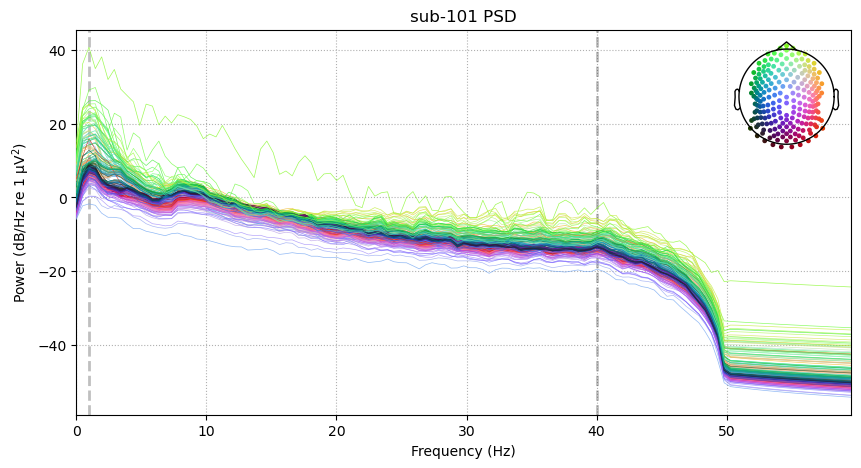

In [11]:
filter_params = {
    "l_freq": 1,
    "h_freq": 40,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
    "picks": ["ecg", "eeg"],
}

zap_filtered = zap.filter(**filter_params).notch_filter(
    freqs=[50], phase="zero", method="iir"
)

fig, ax = plt.subplots(figsize=(10, 5))
raw_psd = zap_filtered.compute_psd(
    fmax=60.0, method="welch", picks="eeg", exclude="bads"
).plot(average=False, picks="eeg", exclude="bads", show=False, axes=ax, amplitude=False)
ax.set_title(f"sub-{subject_id} PSD")

In [12]:
bad_channels_by_ransac = apply_pyprep(zap_filtered, output="dict", as_dict=True)

print(bad_channels_by_ransac["bad_all"])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 s)

Executing RANSAC
This may take a while, so be patient...


/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/mne/channels/interpolation.py:116: RuntimeWarning: divide by zero encountered in matmul
  interpolation = np.hstack([G_to_from, np.ones((n_to, 1))]) @ C_inv[:, :-1]
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/mne/channels/interpolation.py:116: RuntimeWarning: overflow encountered in matmul
  interpolation = np.hstack([G_to_from, np.ones((n_to, 1))]) @ C_inv[:, :-1]
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/mne/channels/interpolation.py:116: RuntimeWarning: invalid value encountered in matmul
  interpolation = np.hstack([G_to_from, np.ones((n_to, 1))]) @ C_inv[:, :-1]
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/pyprep/ransac.py:526: RuntimeWarning: divide by zero encountered in matmul
  eeg_predictions[..., sample] = np.matmul(interp_mat, data[reconstr_idx, :])
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/sit

Finding optimal chunk size : 202
Total # of chunks: 1
Current chunk:
1

RANSAC done!
['E9', 'E132']


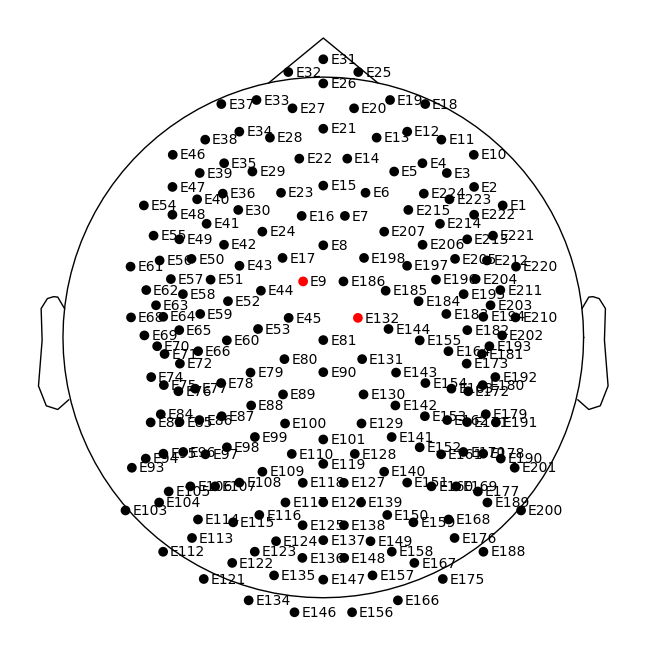

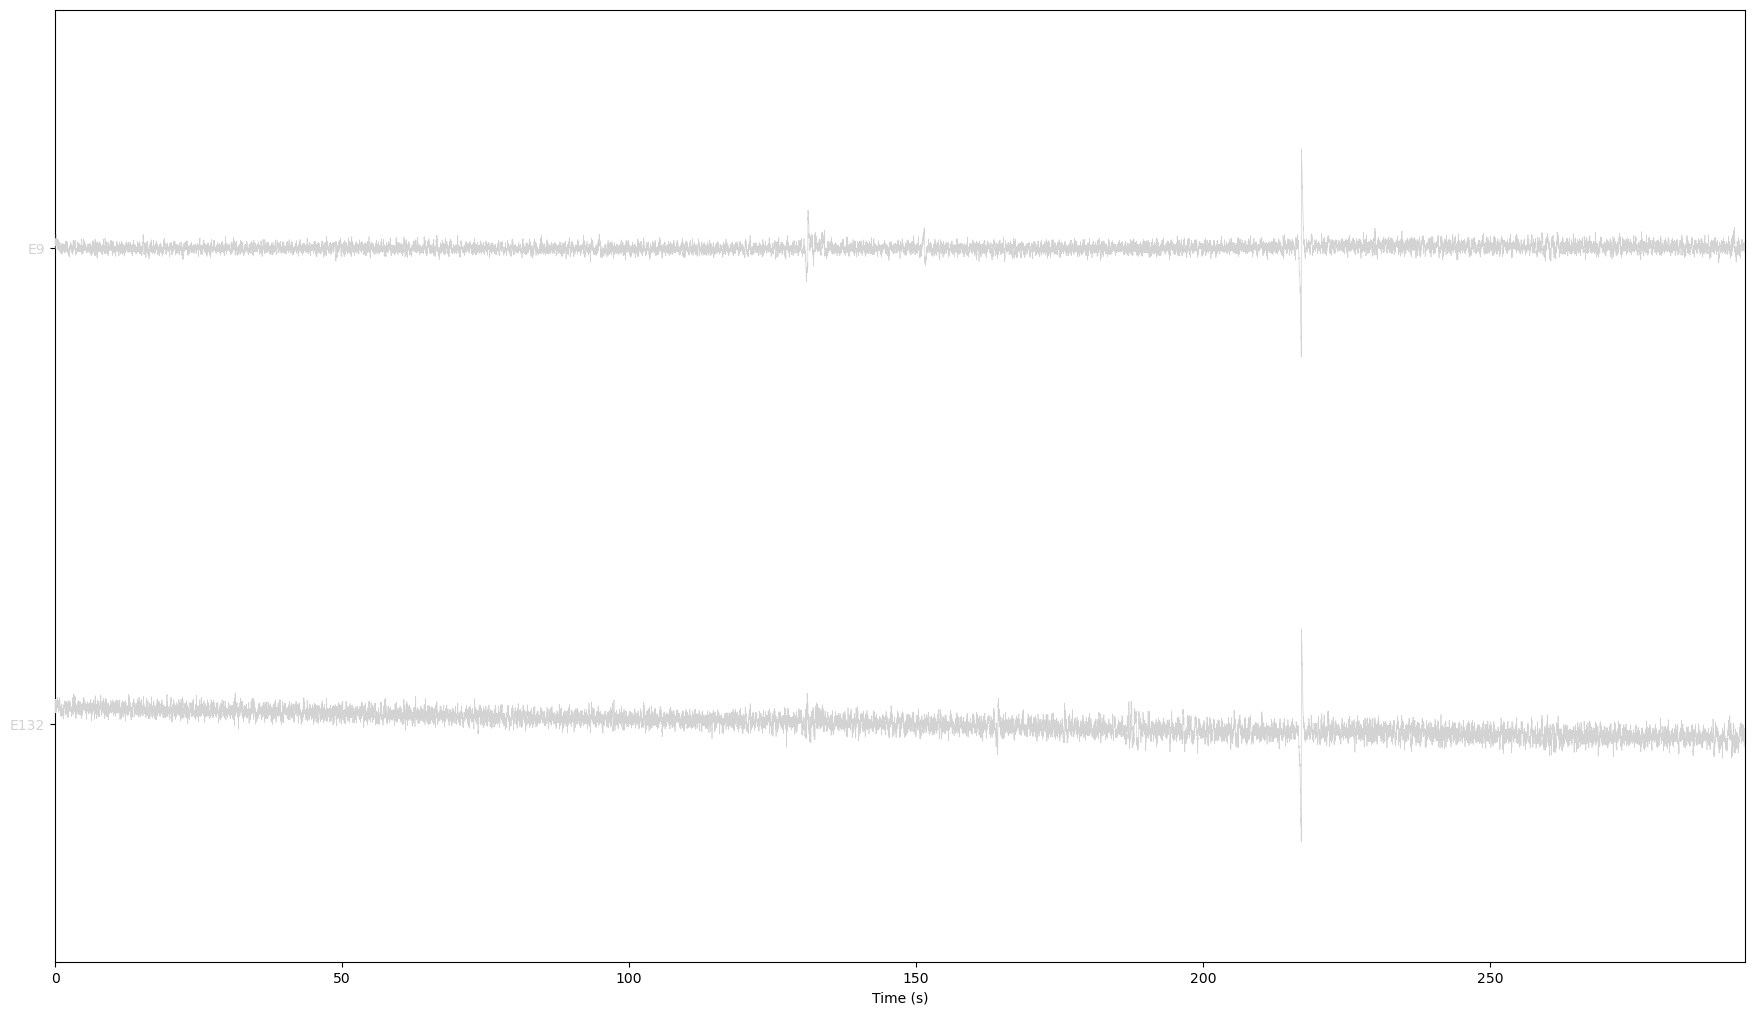

Writing /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/preprocessed/sub-101_filtered_raw.fif
Closing /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/preprocessed/sub-101_filtered_raw.fif
[done]


[PosixPath('/Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/preprocessed/sub-101_filtered_raw.fif')]

In [13]:
zap_ransac = zap_filtered.copy()
zap_ransac.info["bads"].extend(bad_channels_by_ransac["bad_all"])
sensor_plot = zap_ransac.plot_sensors(show_names=True)
zap_ransac.copy().pick(bad_channels_by_ransac["bad_all"]).plot(
    duration=300.0,
    scalings=dict(eeg=1e-4),
    show_scrollbars=False,
)
zap_ransac.save(
    f"{paths.preprocessed}/sub-{subject_id}_filtered_raw.fif", overwrite=True
)

Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 5001 original time points ...


/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/signal/_signaltools.py:4247: RuntimeWarning: divide by zero encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/signal/_signaltools.py:4247: RuntimeWarning: overflow encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/signal/_signaltools.py:4247: RuntimeWarning: invalid value encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef


0 bad epochs dropped


/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/mne/channels/interpolation.py:116: RuntimeWarning: divide by zero encountered in matmul
  interpolation = np.hstack([G_to_from, np.ones((n_to, 1))]) @ C_inv[:, :-1]
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/mne/channels/interpolation.py:116: RuntimeWarning: overflow encountered in matmul
  interpolation = np.hstack([G_to_from, np.ones((n_

fitting finished
Dropped 7 epochs: 36, 37, 38, 39, 61, 62, 82


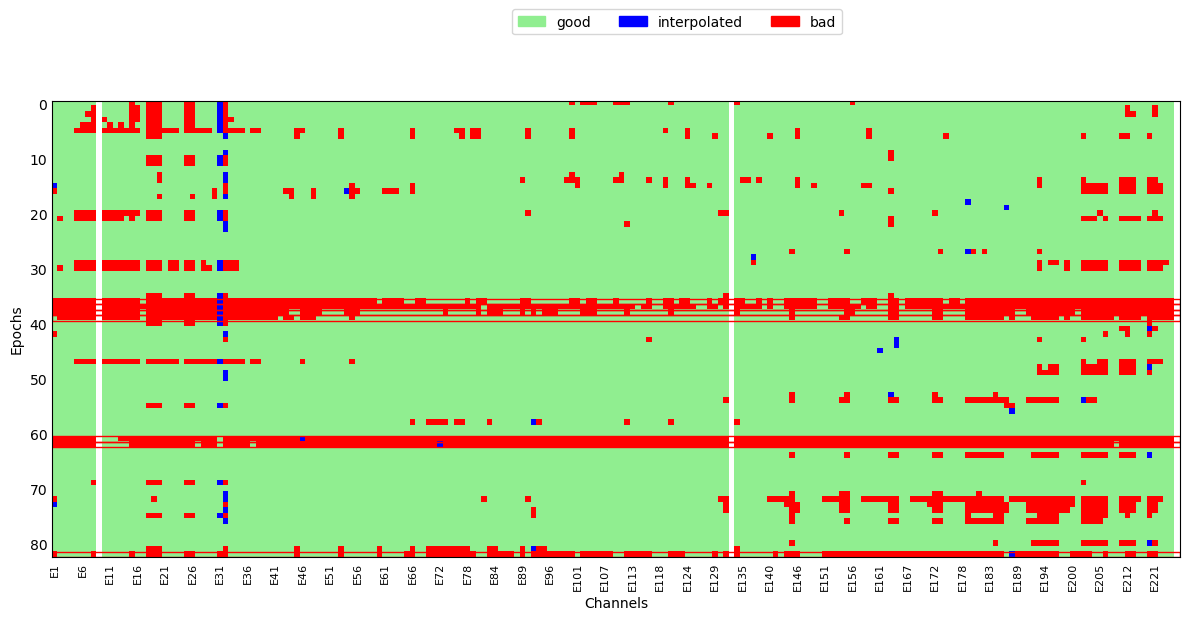

Additional 1 bad channels found:['E32']


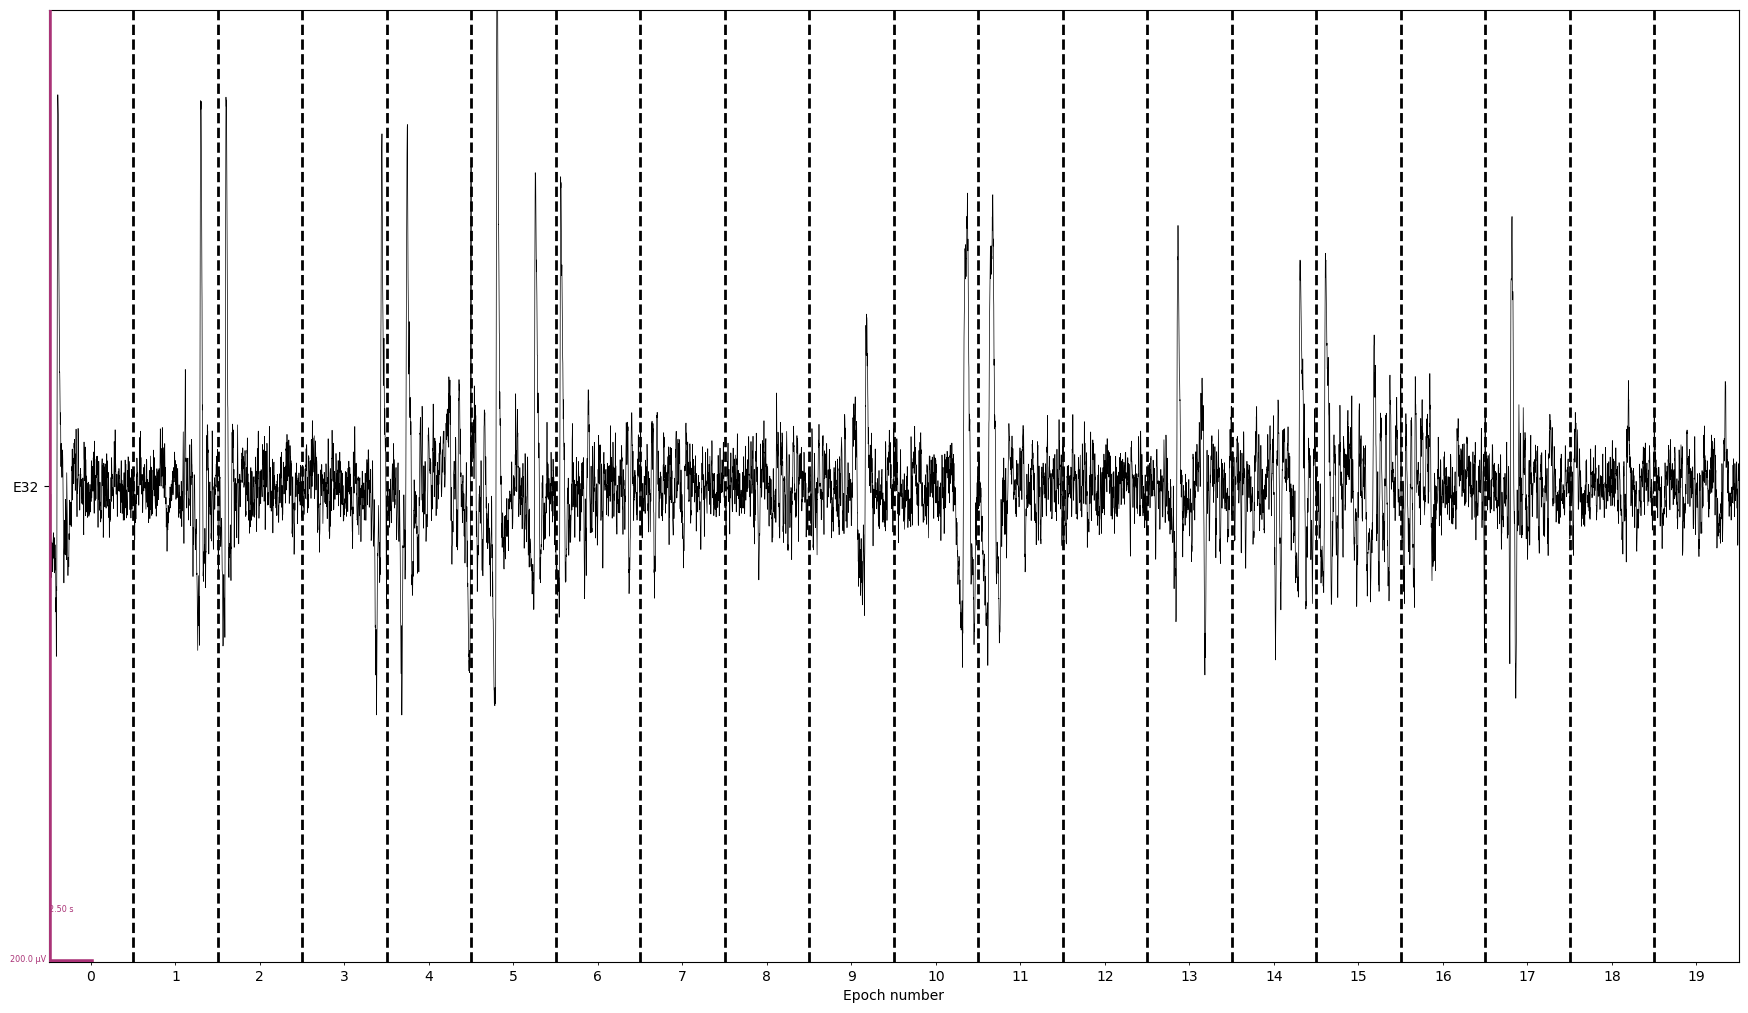

In [14]:
from spectral.epochs import create_epochs, get_reject_log

# raw_annotated = raw_pyprep.copy()
epochs = create_epochs(zap_ransac, overlap=1.5)

reject_log = get_reject_log(epochs, resample=125, n_interpolate=[1], consensus=[0.35])
reject_plot = reject_log.plot("vertical")


# Drop channels with more than 40% bad epochs
BADS_THRESHOLD = 0.40

bads = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)

bad_channel = bads.mean(axis=0)
# print(bad_channel)
epochs.info
channel_names = epochs.info["ch_names"]
bad_channels_by_epochs = [
    name for name, value in zip(channel_names, bad_channel) if value > BADS_THRESHOLD
]
print(
    f"Additional {len(bad_channels_by_epochs)} bad channels found:{
        bad_channels_by_epochs
    }"
)

# epochs.info["bads"].extend(bad_channels_by_epochs)
try:
    bad_channel_plot_additional = epochs.plot(
        picks=bad_channels_by_epochs,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
except Exception as e:
    print(f"An error occurred: {e}")

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


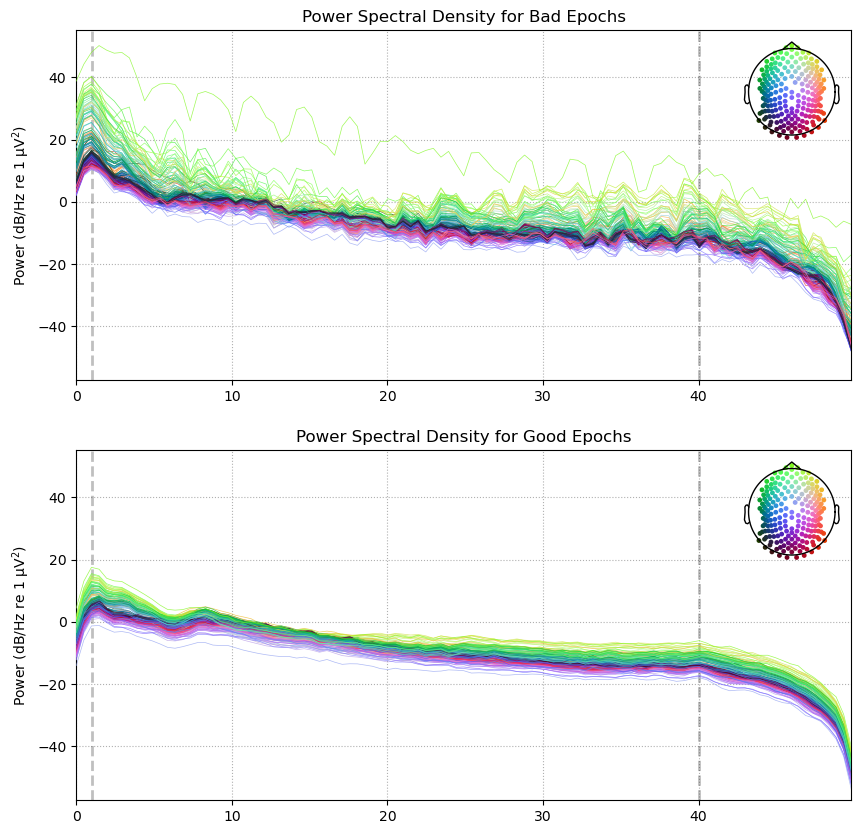

In [15]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

epochs_plot_psd = (
    epochs[reject_log.bad_epochs]
    .compute_psd(method="welch", picks="eeg", fmax=50.0, exclude="bads")
    .plot(
        average=False,
        picks="eeg",
        exclude="bads",
        show=False,
        amplitude=False,
        axes=axs[0],
    )
)
axs[0].set_title("Power Spectral Density for Bad Epochs")

epochs_plot_psd = (
    epochs[~reject_log.bad_epochs]
    .compute_psd(method="welch", picks="eeg", fmax=50.0, exclude="bads")
    .plot(
        average=False,
        picks="eeg",
        exclude="bads",
        show=False,
        amplitude=False,
        axes=axs[1],
    )
)

axs[1].set_title("Power Spectral Density for Good Epochs")


# Get the y-limits of both plots
ylim1 = axs[0].get_ylim()
ylim2 = axs[1].get_ylim()

# Set the same limits on the y-axis for both plots
axs[0].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
axs[1].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))


plt.show()

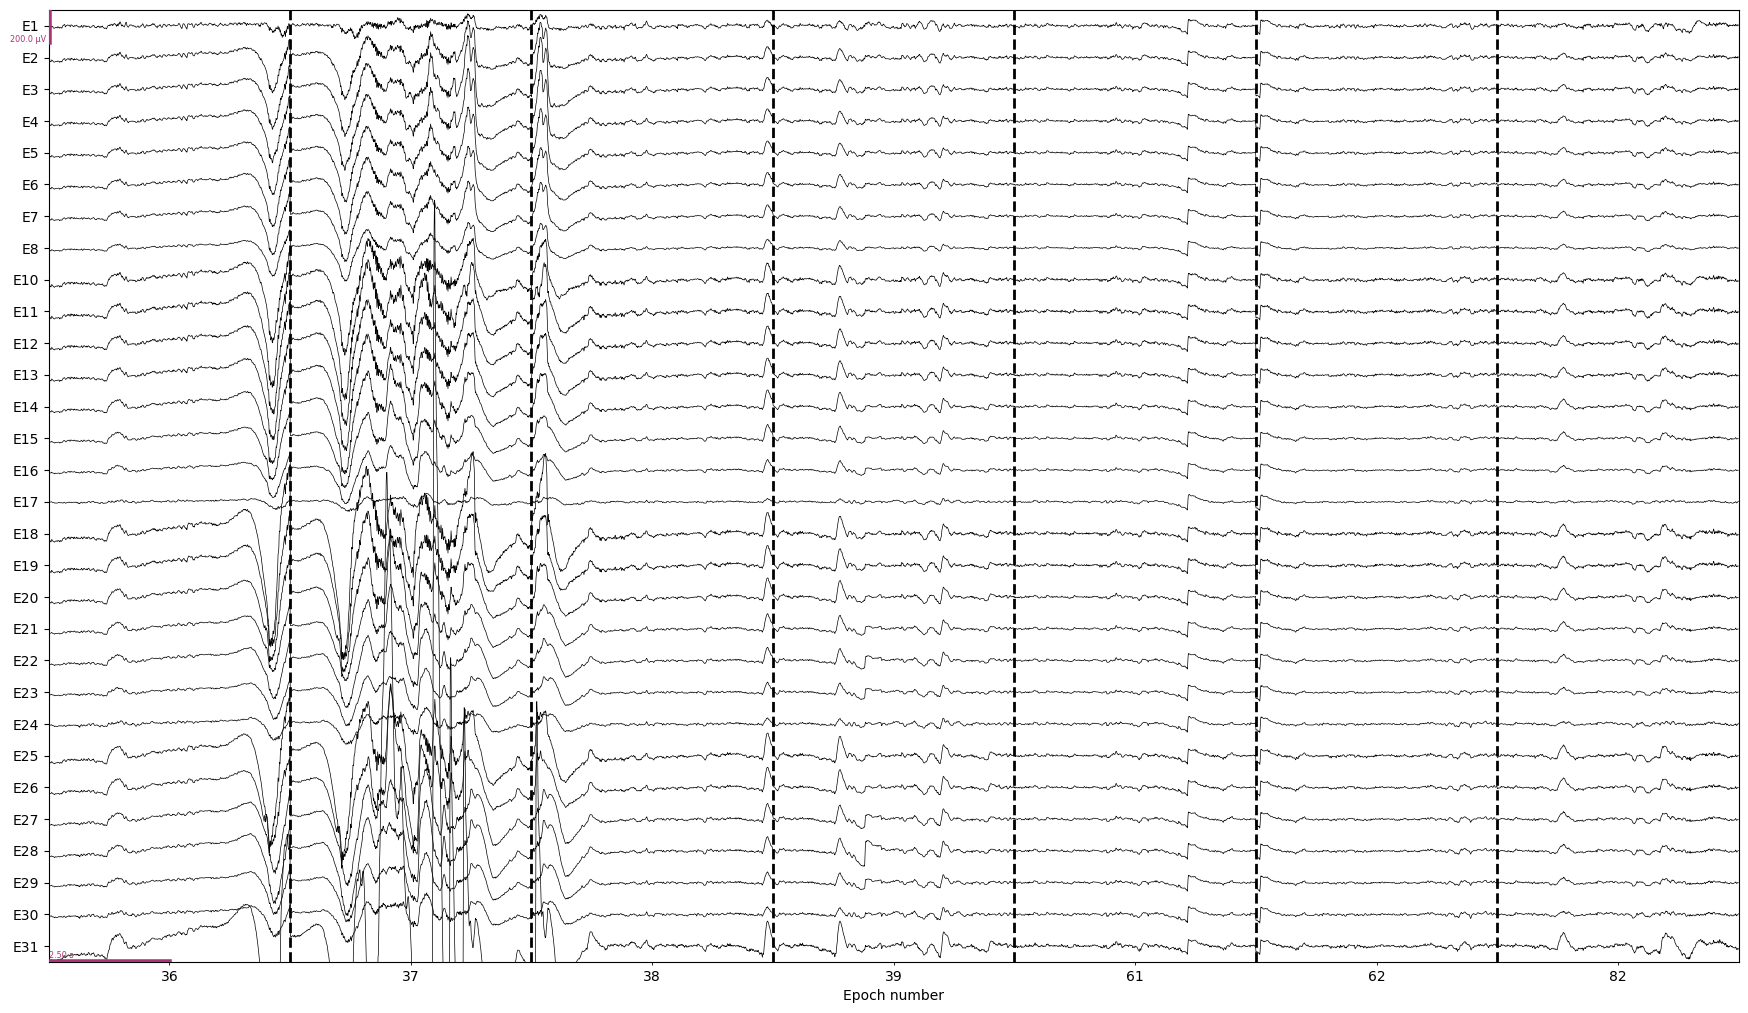

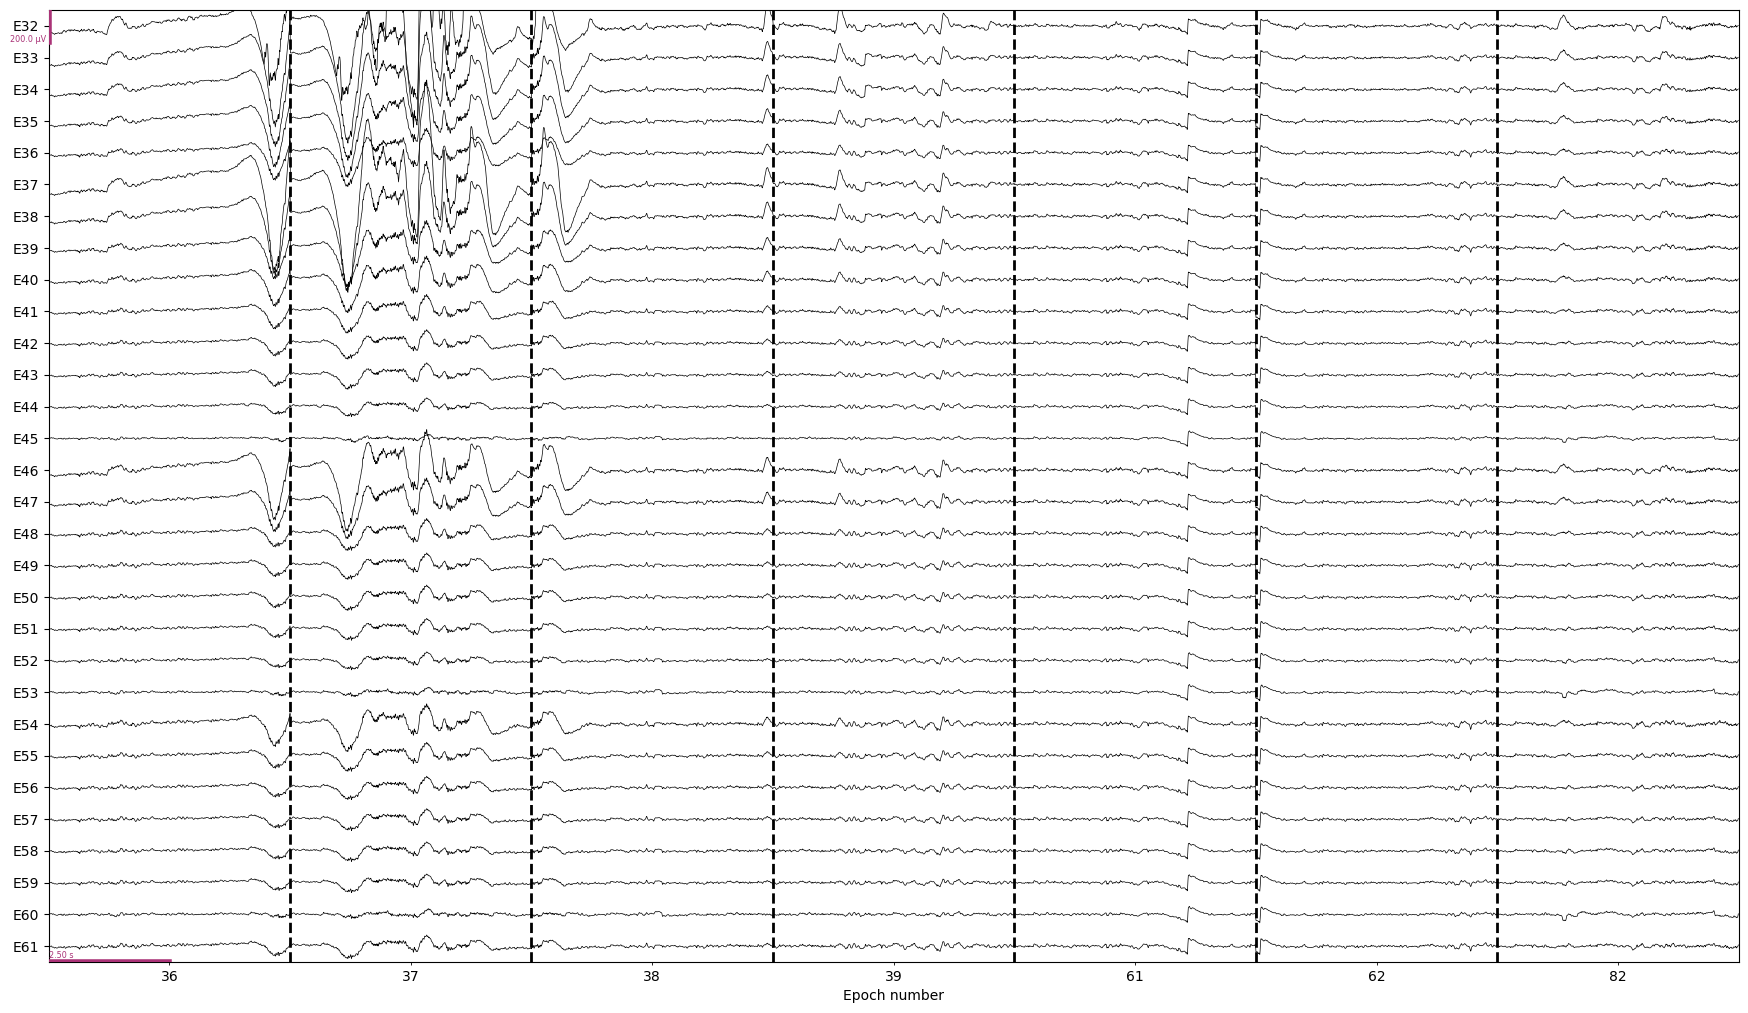

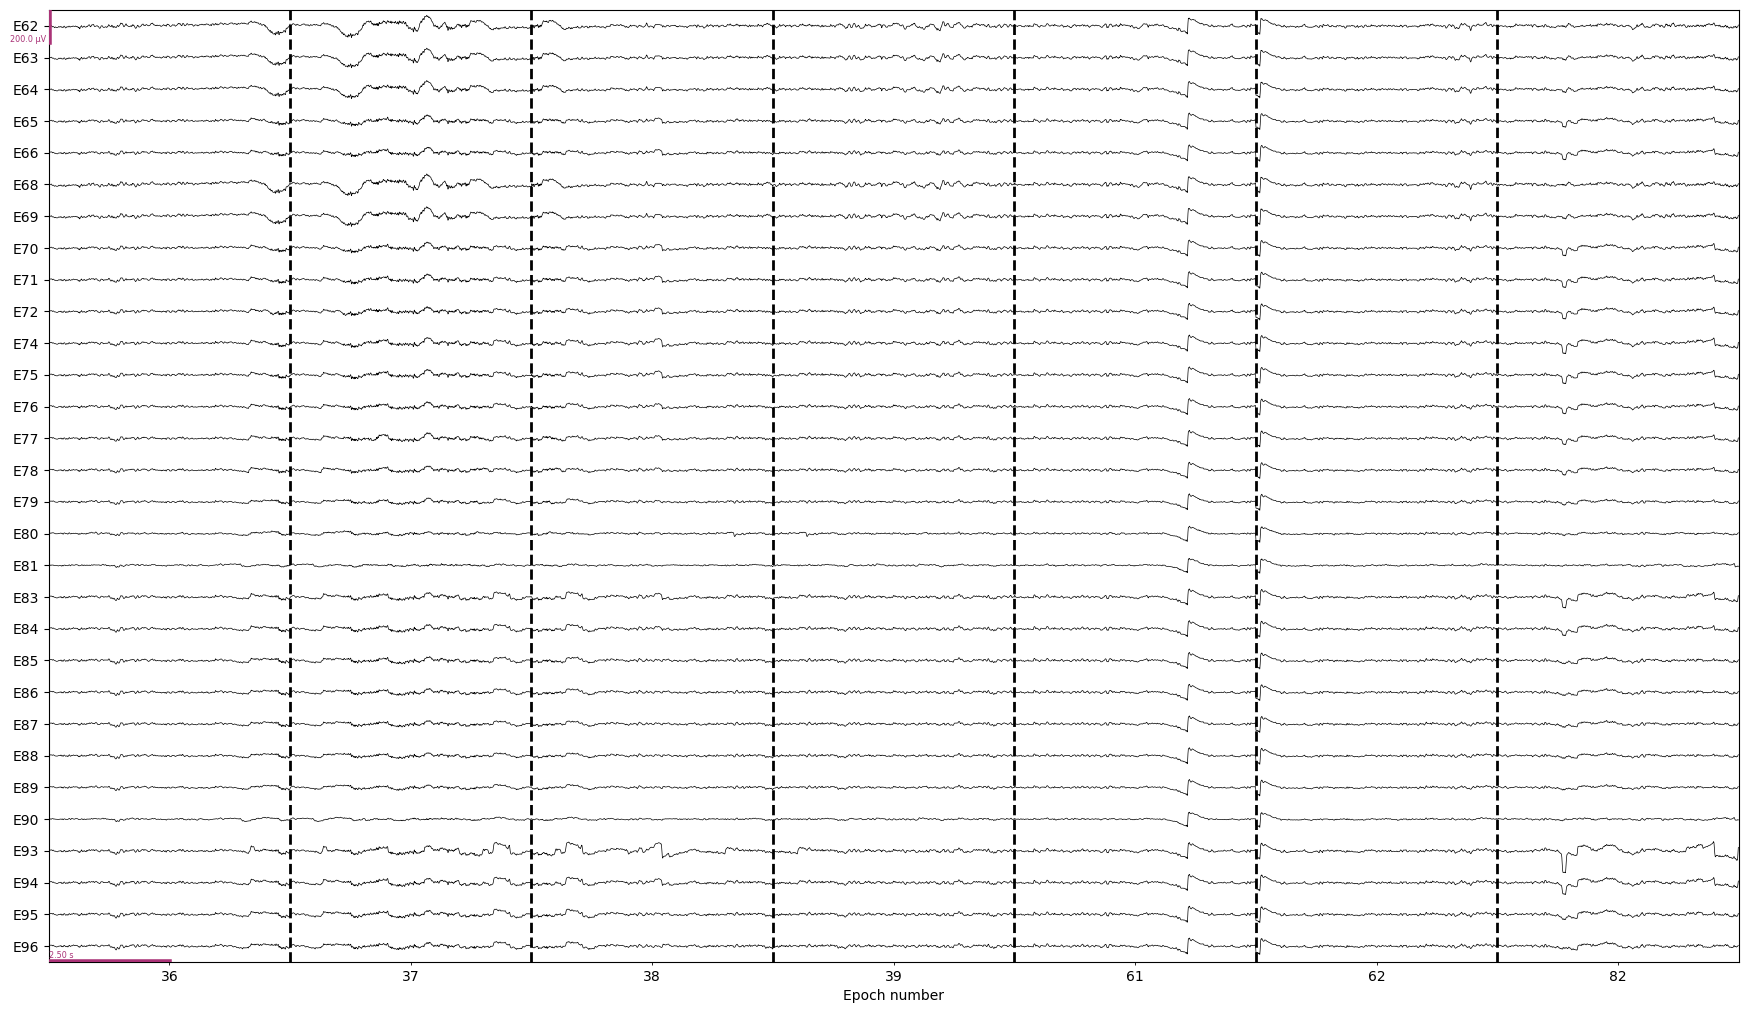

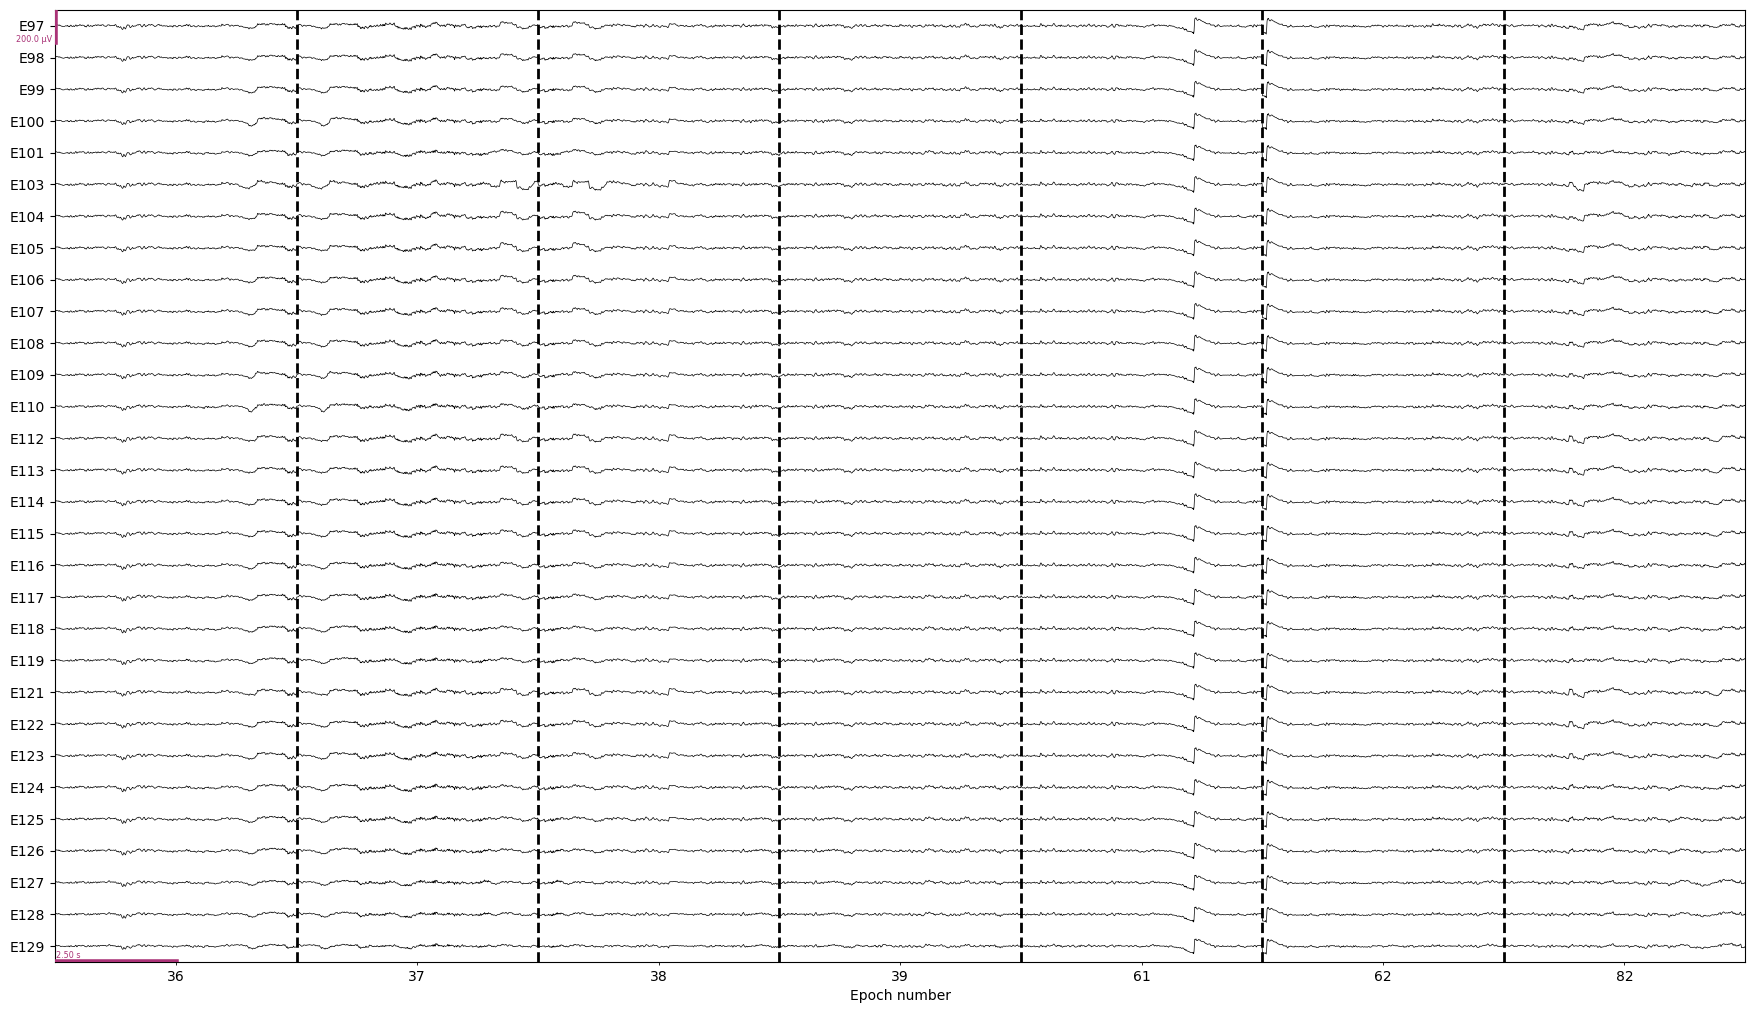

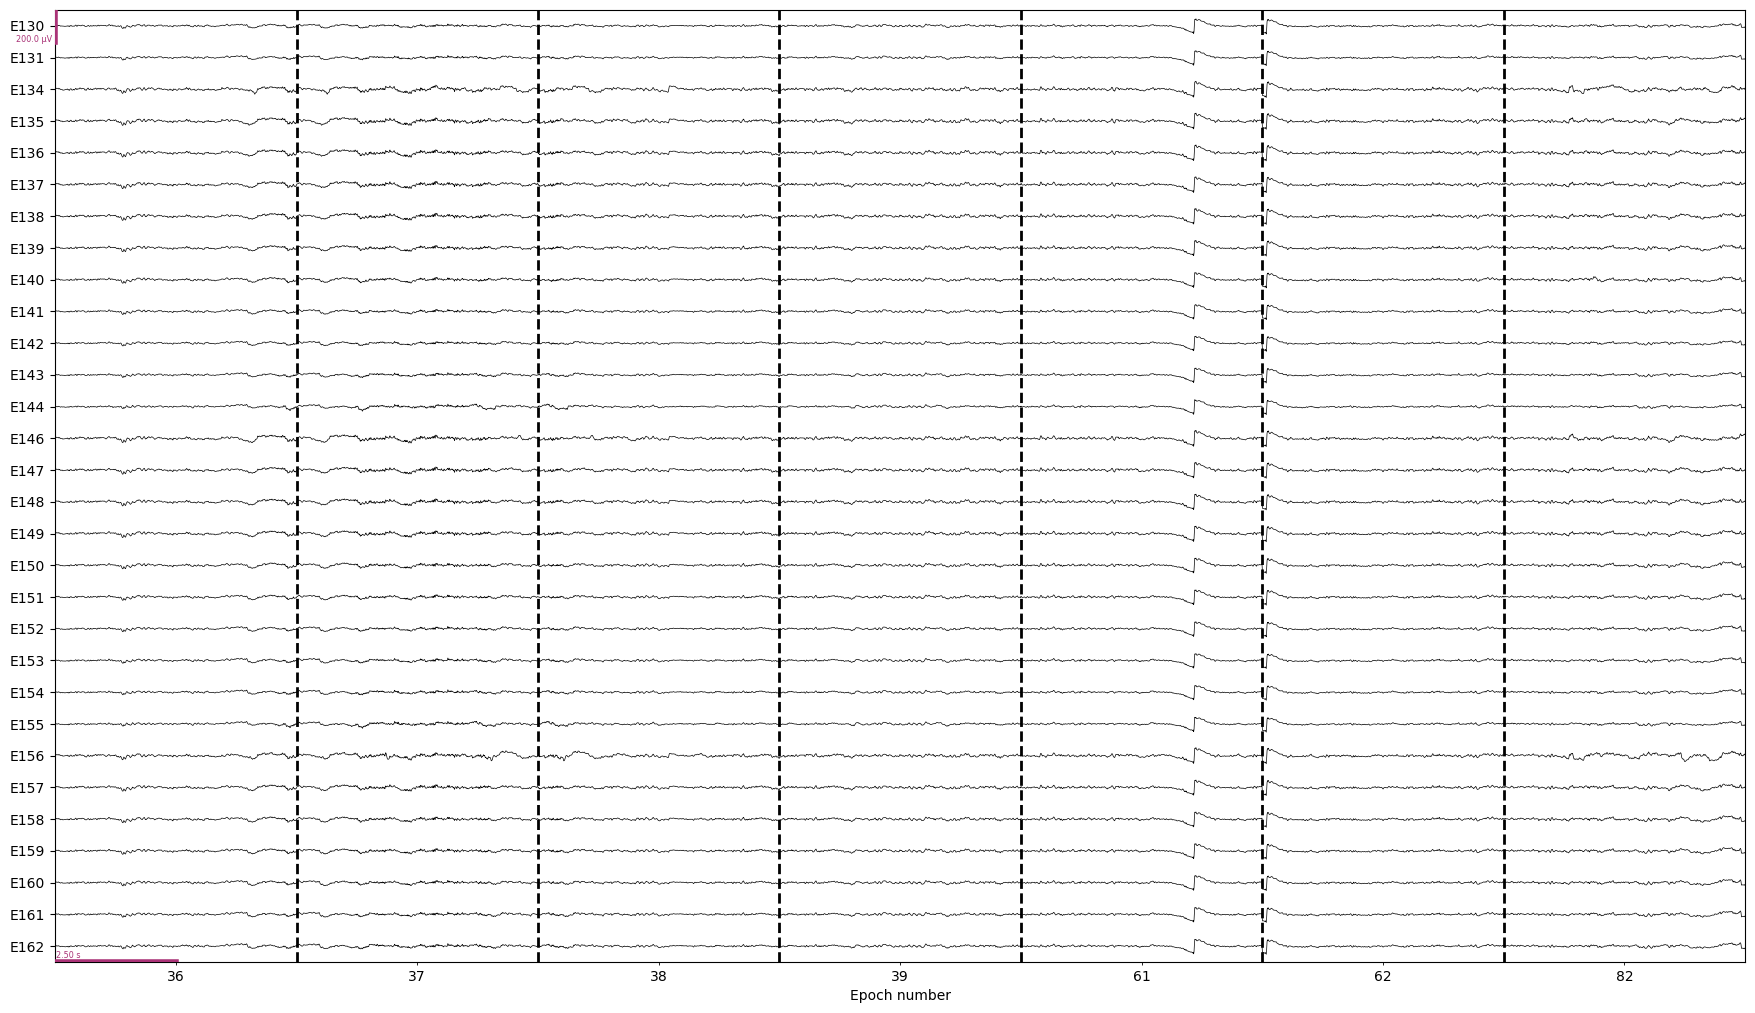

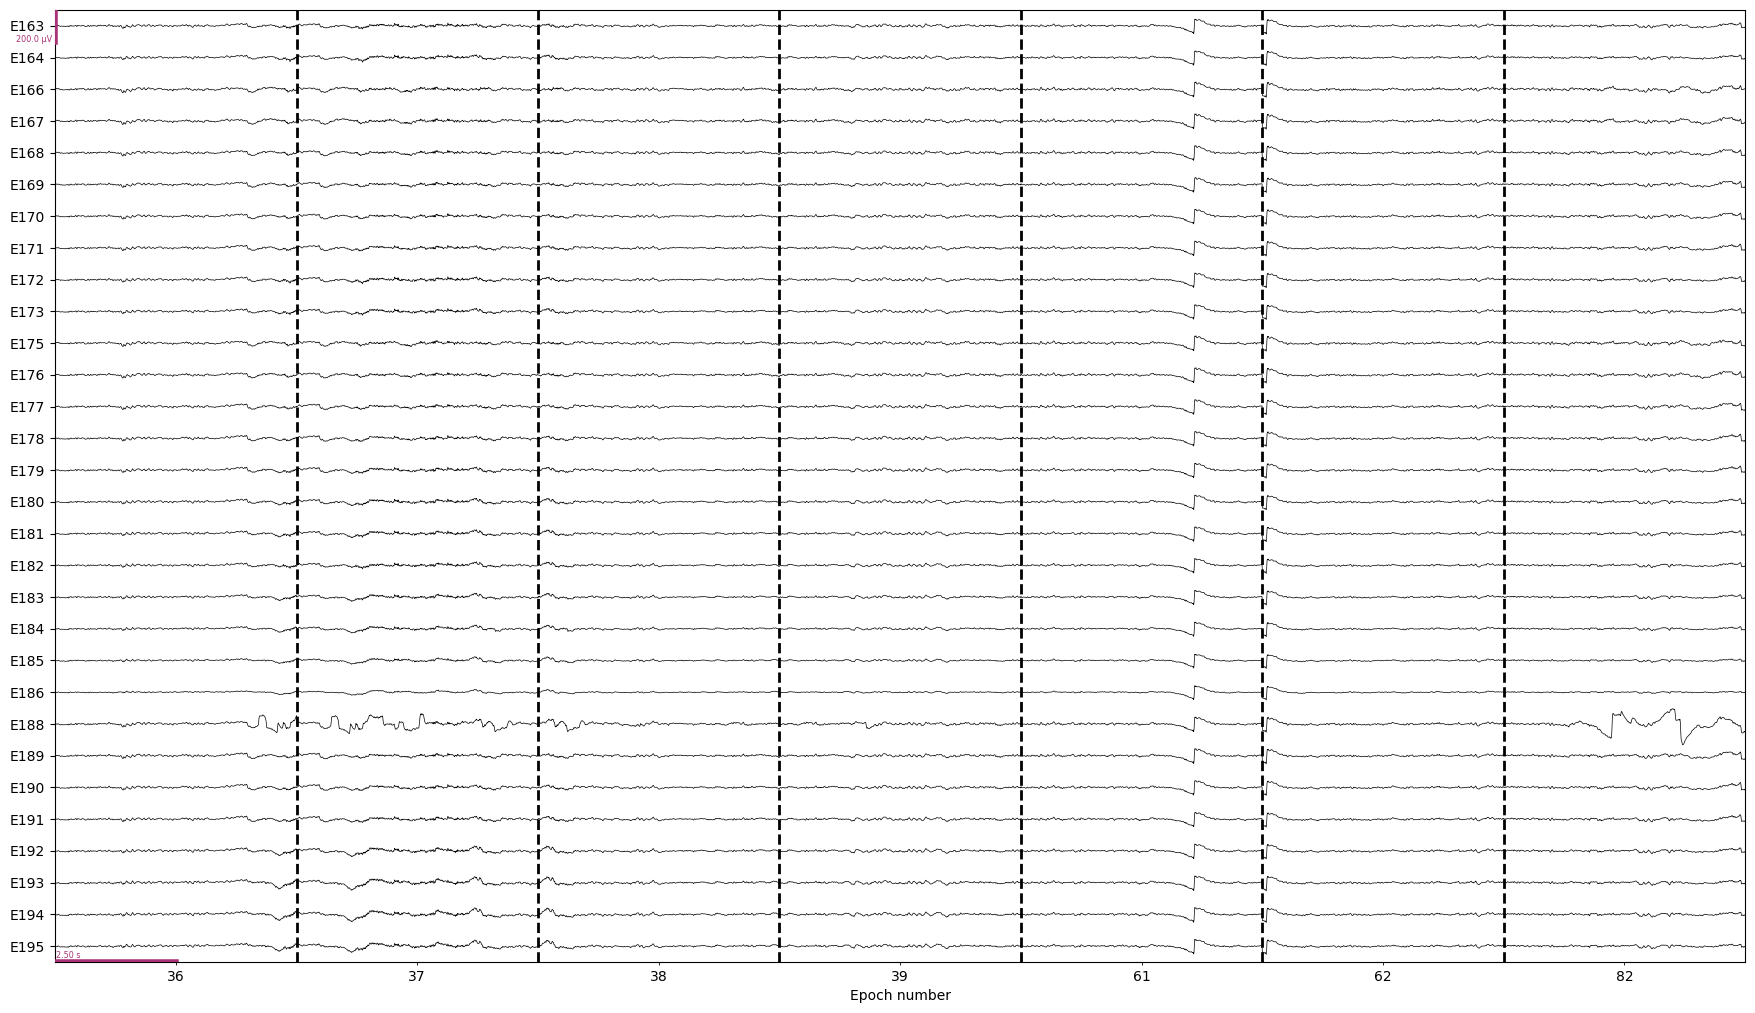

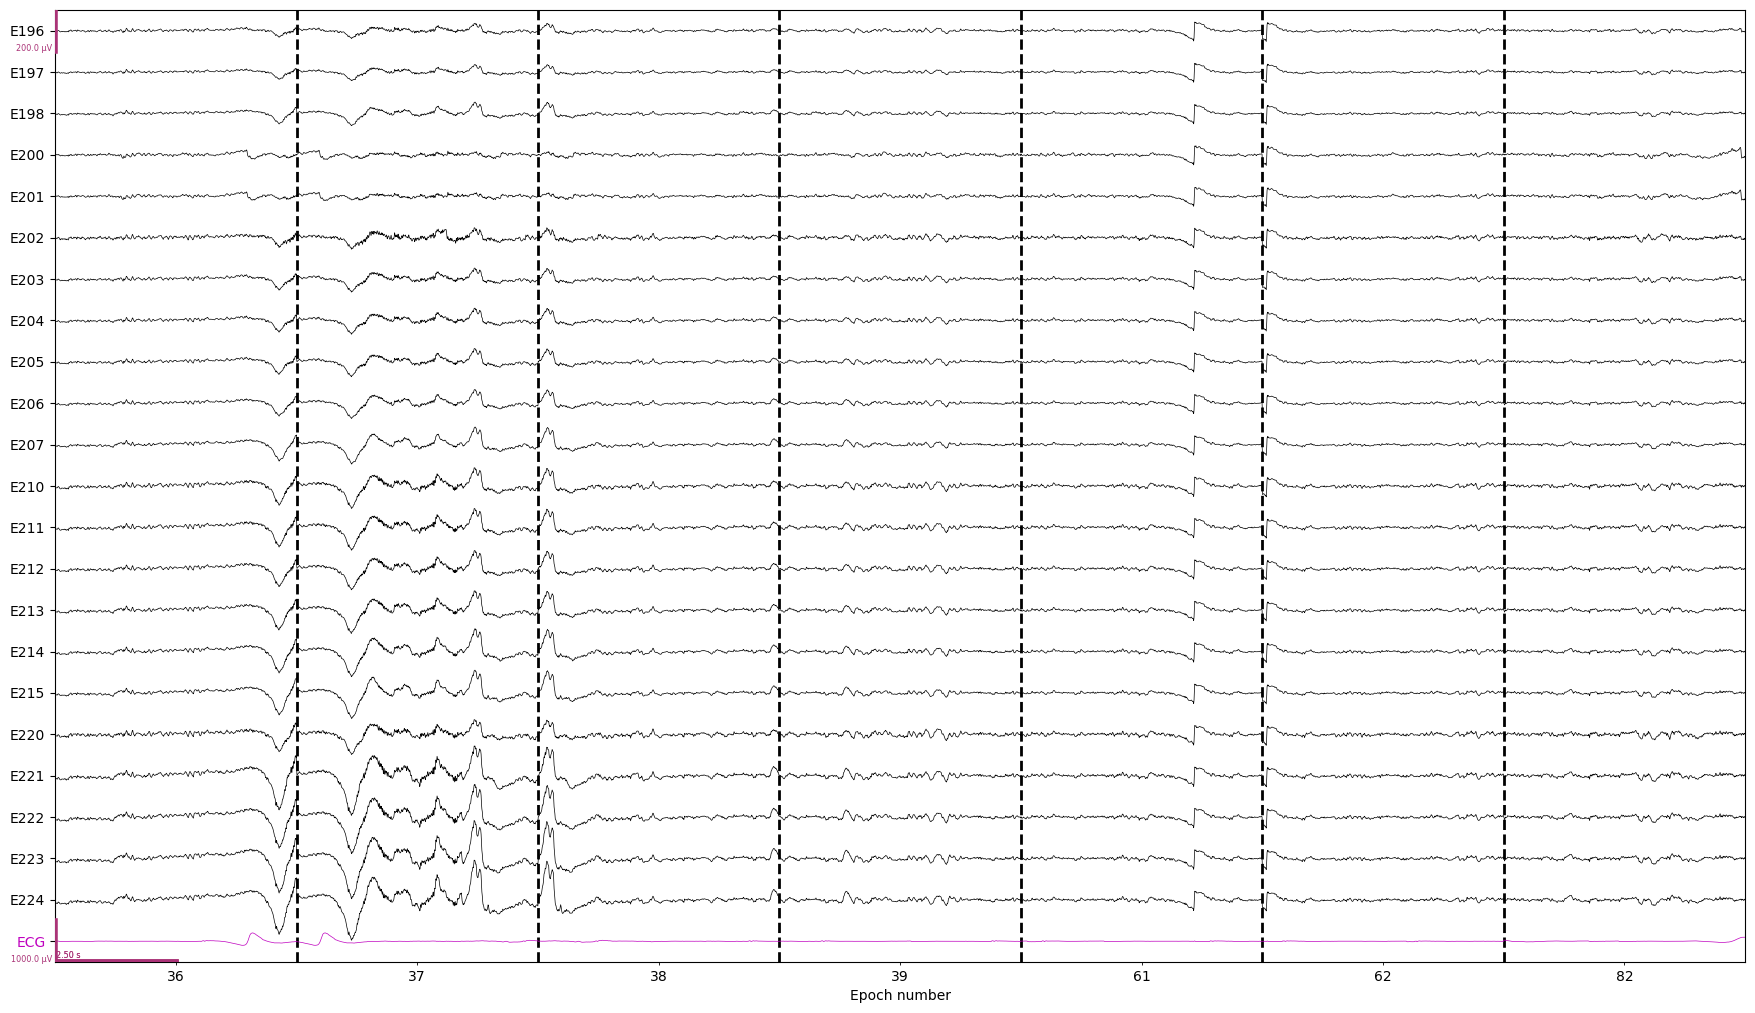

In [16]:
# Assuming 'raw' is your MNE raw object
# Get the list of all channels
all_channels = epochs.info["ch_names"]

# Get the list of bad channels
bad_channels = epochs.info["bads"]

# Get the list of good channels
good_channels = [ch for ch in all_channels if ch not in bad_channels]

# Get the indices of the good channels
good_channels_indices = [all_channels.index(ch) for ch in good_channels]

# Define the chunk size
chunk_size = 30

# Create chunks of the good channels
chunks = [
    good_channels_indices[i : i + chunk_size]
    for i in range(0, len(good_channels_indices), chunk_size)
]


# Now you can iterate over the chunks
for chunk in chunks:
    # Do something with the chunk
    # print(chunk)
    mne.viz.plot_epochs(
        epochs=epochs[reject_log.bad_epochs],
        picks=chunk,
        show=False,
        scalings=dict(eeg=1e-4),
        n_channels=chunk_size,
        show_scrollbars=False,
    )

In [17]:
print(f"Sub{subject_id} -  removed {sum(reject_log.bad_epochs)} epochs")
print(f"Sub{subject_id} -  retained {len(epochs[~reject_log.bad_epochs])} epochs")

epochs_good = epochs[~reject_log.bad_epochs]
epochs_good.save(
    f"{paths.epochs}/sub-{subject_id}_good_epochs-epo.fif", overwrite=True
)

Sub101 -  removed 7 epochs
Sub101 -  retained 76 epochs


[PosixPath('/Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/epochs/sub-101_good_epochs-epo.fif')]

In [18]:
from spectral.epochs import create_epochs, get_reject_log
from spectral.preproc import load_config

def find_bad_segments(raw: mne.io.Raw, 
                      epoch_length: float = 1.0, 
                      overlap: float = 0.0,
                      resample_sfreq: int = 125) -> mne.Annotations:
    """
    Identifies bad data segments using short epochs and autoreject.

    Args:
        raw (mne.io.Raw): The raw MNE data object, minimally filtered.
        epoch_length (float): The length of the short epochs for artifact detection.
        overlap (float): The overlap between short epochs.
        resample_sfreq (int): The frequency to resample to before running autoreject.

    Returns:
        mne.Annotations: MNE annotations marking the identified bad time segments.
    """
    print(f"Finding bad segments using {epoch_length}s epochs...")
    
    # 1. Create short epochs for artifact detection
    epochs = create_epochs(raw, length=epoch_length, overlap=overlap)
    
    # 2. Get the reject log from these short epochs
    reject_log = get_reject_log(epochs, resample=resample_sfreq, consensus=[0.35])
    
    # 3. Convert the reject log to annotations
    bad_annotations = reject_log_to_annotations(reject_log, epochs)
    
    print(f"Found {len(bad_annotations)} bad segments to be marked.")
    return bad_annotations

def reject_log_to_annotations(epochs: mne.Epochs, bad_epoch_indices: np.ndarray) -> mne.Annotations:
    """
    Convert a list of bad epoch indices into MNE annotations.

    Args:
        epochs: The MNE epochs object from which the reject_log was generated.
        bad_epoch_indices: NumPy array of indices for epochs to be marked as bad.

    Returns:
        mne.Annotations: Annotations object marking the bad segments.
    """
    if len(bad_epoch_indices) == 0:
        return mne.Annotations(onset=[], duration=[], description=[])

    # Get the event timings from the epochs object for the bad indices
    onsets = epochs.events[bad_epoch_indices, 0] / epochs.info["sfreq"]
    duration = len(epochs.times) / epochs.info["sfreq"]

    bad_annotations = mne.Annotations(
        onset=onsets,
        duration=[duration] * len(onsets),
        description=["bad_segment"] * len(onsets),
        orig_time=epochs.info.get('meas_date')
    )

    return bad_annotations

def find_bad_segments(raw: mne.io.Raw, 
                      epoch_length: float = 1.0, 
                      bad_epoch_threshold: float = 0.2,
                      **kwargs) -> mne.Annotations:
    """
    Identifies bad data segments using short epochs and a combined autoreject criterion.

    An epoch is marked as a "bad segment" if the fraction of its channels marked
    for rejection or interpolation exceeds `bad_epoch_threshold`.

    Args:
        raw (mne.io.Raw): The raw MNE data object, minimally filtered.
        epoch_length (float): The length of the short epochs for artifact detection.
        bad_epoch_threshold (float): Fraction of channels needing to be bad/interpolated
                                     to mark the entire epoch as a bad segment.
        **kwargs: Additional arguments passed to get_reject_log (e.g., consensus).

    Returns:
        mne.Annotations: MNE annotations marking the identified bad time segments.
    """
    print(f"Finding bad segments using {epoch_length}s epochs...")
    
    epochs = create_epochs(raw, length=epoch_length, overlap=0.0)
    reject_log = get_reject_log(epochs, **kwargs) 
    # [cite_start]Combine bad and interpolated channels to define unreliable channels [cite: 696]
    unreliable_channels = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)
    
    # Calculate the fraction of unreliable channels for each epoch
    fraction_unreliable_per_epoch = unreliable_channels.mean(axis=1)
    
    # Find epochs where this fraction exceeds our threshold
    bad_epoch_indices = np.where(fraction_unreliable_per_epoch > bad_epoch_threshold)[0]
    
    # Convert the indices of these bad epochs to annotations
    bad_annotations = reject_log_to_annotations(epochs, bad_epoch_indices)
    
    print(f"Found {len(bad_annotations)} segments to annotate as 'bad'.")
    return bad_annotations


raw_for_ar = raw_filtered.copy()
epochs = create_epochs(raw_for_ar, length=3, overlap=1.5) 
reject_log = get_reject_log(epochs, resample=125, consensus=[0.35]) 

bad_annotations = find_bad_segments(
    raw_for_ar, 
    epoch_length=1.0, 
    bad_epoch_threshold=0.2,
    resample=125,
    consensus=[0.35]
)

# Add the identified bad segments as annotations
raw.set_annotations(raw.annotations + bad_annotations)
# Add these annotations to the *original* raw data
raw.set_annotations(raw.annotations + bad_annotations)
raw.save(
    f"{paths.preprocessed}/sub-{subject_id}_annotated.fif", overwrite=True
)


Not setting metadata
195 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 195 events and 751 original time points ...


/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/signal/_signaltools.py:4247: RuntimeWarning: divide by zero encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/signal/_signaltools.py:4247: RuntimeWarning: overflow encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/signal/_signaltools.py:4247: RuntimeWarning: invalid value encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef


2 bad epochs dropped


/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/mne/channels/interpolation.py:116: RuntimeWarning: divide by zero encountered in matmul
  interpolation = np.hstack([G_to_from, np.ones((n_to, 1))]) @ C_inv[:, :-1]
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/mne/channels/interpolation.py:116: RuntimeWarning: overflow encountered in matmul
  interpolation = np.hstack([G_to_from, np.ones((n_

fitting finished
Dropped 22 epochs: 0, 14, 31, 35, 37, 49, 83, 84, 85, 86, 87, 88, 89, 92, 93, 143, 144, 169, 170, 174, 191, 192
Finding bad segments using 1.0s epochs...
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 294 events and 251 original time points ...


/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/signal/_signaltools.py:4247: RuntimeWarning: divide by zero encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/signal/_signaltools.py:4247: RuntimeWarning: overflow encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/signal/_signaltools.py:4247: RuntimeWarning: invalid value encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef


3 bad epochs dropped


/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/scipy/linalg/_basic.py:1648: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/mne/channels/interpolation.py:116: RuntimeWarning: divide by zero encountered in matmul
  interpolation = np.hstack([G_to_from, np.ones((n_to, 1))]) @ C_inv[:, :-1]
/Users/daniel/.pyenv/versions/psd-paths-3.13/lib/python3.13/site-packages/mne/channels/interpolation.py:116: RuntimeWarning: overflow encountered in matmul
  interpolation = np.hstack([G_to_from, np.ones((n_

fitting finished
Dropped 66 epochs: 0, 7, 16, 21, 22, 34, 39, 49, 53, 54, 56, 57, 61, 70, 73, 75, 76, 80, 89, 93, 97, 98, 105, 109, 111, 127, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 153, 164, 166, 167, 170, 189, 194, 195, 216, 217, 221, 222, 226, 228, 234, 241, 248, 253, 255, 260, 261, 262, 265, 266, 268, 271, 283, 288, 289, 290
Found 105 segments to annotate as 'bad'.
Writing /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/preprocessed/sub-101_annoted.fif


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_96618/1669438897.py:117: RuntimeWarning: This filename (/Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/preprocessed/sub-101_annoted.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(


Closing /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/preprocessed/sub-101_annoted.fif
[done]


[PosixPath('/Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/preprocessed/sub-101_annoted.fif')]

In [15]:
print(bad_annotations)

<Annotations | 105 segments: bad_segment (105)>
